<u><b>Deep Learning : Principles and Practices - CSE1016 - D1 Slot</b></u>

<u><b>Name:</b></u> Gaurav Pendharkar

<u><b>Registration No:</b></u> 20BAI1153

<u><b>Digital Assignment - 1 :</b></u> A Simple Project

<h3> <b> <u> Domain Adaptation of ResNet50 model for Peripherial Blood Cell Classification </u> </b> </h3>

# Importing the required modules

In [3]:
# Modules used for data handling and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules used for splitting the data into train, test, and validation sets.
import splitfolders
import os

# Modules used for randomisation.
import random as r

# Modules used for specifying type hints for function parameters.
from typing import Type

# Modules used for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

# Modules used for evaluating the model
from sklearn.metrics import accuracy_score, classification_report

# Loading the dataset

We define a class Dataset with the following modules:
   - Class Distribution of the dataset
   - Show sample of each class
   - Test, Train, and Validation Split of the dataset

In [36]:
class Dataset:

    def __init__(self, IMG_DIR : str, TRAIN : float, TEST : float, VAL : float, split_dest : str):
        self.DIR = IMG_DIR
        self.class_dist = dict()
        self.TRAIN = TRAIN
        self.TEST = TEST
        self.VAL = VAL
        self.SPLIT_DEST = split_dest 
    
    def __compute_class_distributions(self) -> None:
        for dirname in os.listdir(self.DIR):
            self.class_dist[dirname] = len(os.listdir(os.path.join(self.DIR, dirname)))

    def class_distribution(self) -> None:
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_dist.keys(),
        self.class_dist.values(),
        color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of Cell Types dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_samples(self) -> None:
        rows = 2
        columns = 4
        c = 0
        fig, axs = plt.subplots(rows, columns,figsize=(10,10))
        for dirname in os.listdir(self.DIR):
            img_path = r.choice(os.listdir(os.path.join(self.DIR, dirname)))
            image = mpimg.imread(os.path.join(self.DIR, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
        fig.suptitle("Image Samples of Cell Classification dataset")
        plt.subplots_adjust(bottom=0.35, top=0.98, hspace=0.15)
        plt.show()

    def test_train_validation_split(self):
        assert round(self.TRAIN + self.TEST + self.VAL) == 1

        splitfolders.ratio(input = self.DIR, 
                           output = self.SPLIT_DEST,
                           seed = 1337, ratio = (self.TRAIN, self.VAL, self.TEST), 
                           group_prefix = None, 
                           move = False)

## Initialising the Dataset Loading

In [5]:
cell_type = Dataset(IMG_DIR="../data/cell-images", 
                    TRAIN=0.8, TEST=0.1, VAL=0.1,
                    split_dest="../data/bloods-cells-splitted")

## Class Distribution

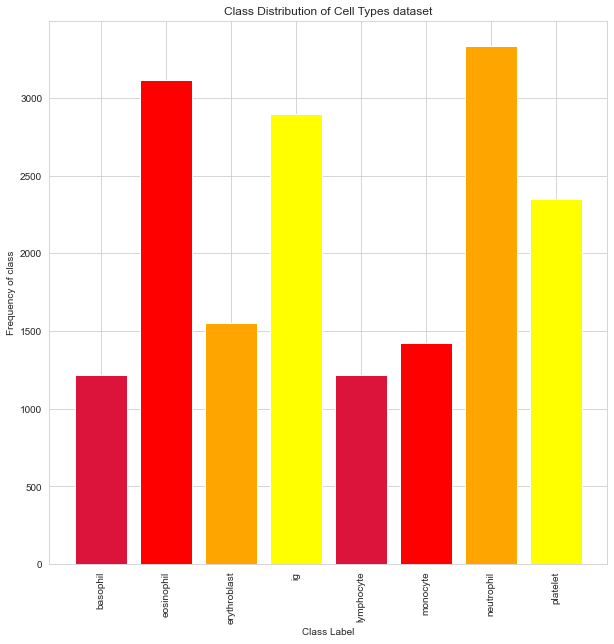

In [6]:
cell_type.class_distribution()

We can observe that eosinophils, ig, and neutrophils have the highest number of images for training while there are relatively few images for other classes. Hence, we will divide the images into three directories train, test, and validation proportionally.

## Sample Images

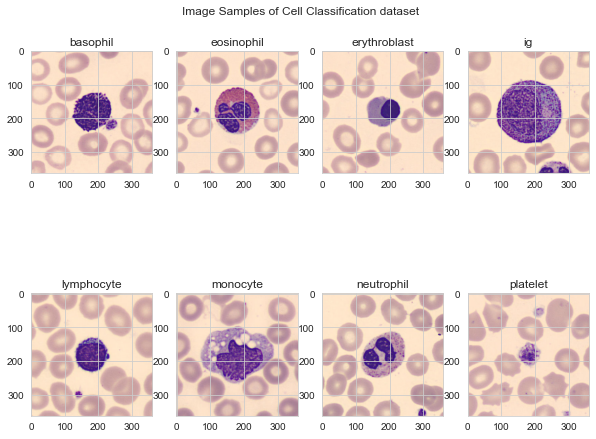

In [7]:
cell_type.show_samples()

## Test, Train, and Validation Split

Here, we split the dataset into three directories as specified above into the ratio of 80 : 10 : 10 (Train : Test : Validation)

In [12]:
cell_type.test_train_validation_split()

Copying files: 17092 files [02:26, 116.43 files/s]


# Image Processing

We define a class Image Processor which aims at preprocessing of the images based on the model requirements and converting them into an appropriate representation. The class Image Processor has the following modules:
   - Creation of the Generators
   - Representation of the images

In [2]:
class ImageProcessor:

    def __init__(self, PARENT_DIR : str):
        self.TRAIN_DIR = os.path.join(PARENT_DIR, "train")
        self.VAL_DIR = os.path.join(PARENT_DIR, "val")
        self.TEST_DIR = os.path.join(PARENT_DIR, "test")
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training'
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

## Image Pre-processing

### Initializing the Image Preprocessor

In [9]:
img_pre = ImageProcessor("../data/bloods-cells-splitted")

### Preprocessing the images according to the model requirements

In [10]:
img_pre.create_generators()

### Extract the images in the appropriate representation

In [11]:
train, val, test = img_pre.get_images()

Found 13671 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.


# Model Building

We define a class Model Builder class which is used to load a pretrained model and add a final layer according to the classification problem at hand. The class has the following modules:
   - Designing the model
   - Compiling the model
   - Fitting the model
   - Plotting the learning curves for the model

In [26]:
class ModelBuilder:

    def __init__(self, train, val):
        self.train = train
        self.val = val
        self.model = None
        self.history = None
    
    def __load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def __mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False
    
    def __add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(8, activation = 'softmax')(self.x)

    def design_model(self):
        self.__load_model()
        self.__mark_layers_non_trainable()
        self.__add_final_layer()

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

    def fit_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=10, validation_data=self.val)

    def visualize_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Initializing the Model Builder

In [27]:
resnet50 = ModelBuilder(train, val)

## Designing the model

In [28]:
resnet50.design_model()

## Compiling the model

In [29]:
resnet50.compile_model()

## Fitting the model

In [30]:
resnet50.fit_model()

Epoch 1/10
428/428 [==============================] - 273s 624ms/step - loss: 1.7276 - accuracy: 0.7290 - val_loss: 0.6260 - val_accuracy: 0.8070
Epoch 2/10
428/428 [==============================] - 258s 602ms/step - loss: 0.4008 - accuracy: 0.8569 - val_loss: 0.5732 - val_accuracy: 0.8147
Epoch 3/10
428/428 [==============================] - 259s 605ms/step - loss: 0.2822 - accuracy: 0.8966 - val_loss: 0.4874 - val_accuracy: 0.8452
Epoch 4/10
428/428 [==============================] - 252s 589ms/step - loss: 0.2199 - accuracy: 0.9207 - val_loss: 0.5211 - val_accuracy: 0.8375
Epoch 5/10
428/428 [==============================] - 249s 581ms/step - loss: 0.1805 - accuracy: 0.9369 - val_loss: 0.4481 - val_accuracy: 0.8669
Epoch 6/10
428/428 [==============================] - 270s 632ms/step - loss: 0.1655 - accuracy: 0.9416 - val_loss: 0.5666 - val_accuracy: 0.8510
Epoch 7/10
428/428 [==============================] - 251s 587ms/step - loss: 0.1402 - accuracy: 0.9497 - val_loss: 0.7947 -

## Learning Curve of the default model

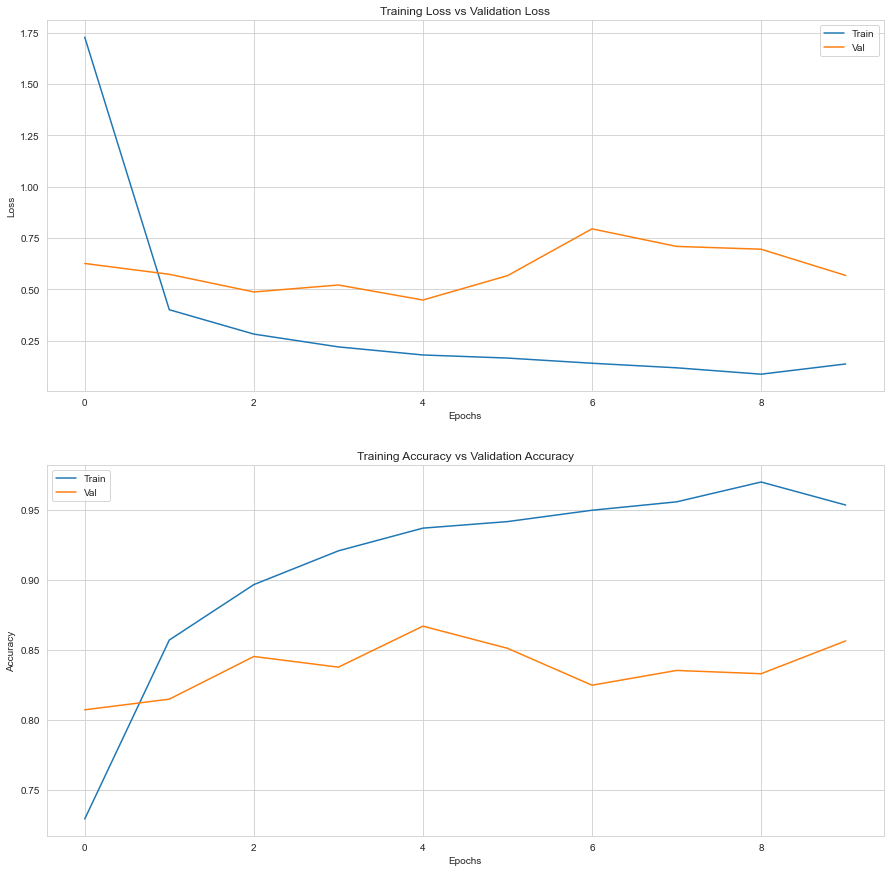

In [31]:
resnet50.visualize_history()

- It is clearly observed that in the later epochs the model has started to get overfitted to the training data resulting in a low bias and high variance. 
- Hence, we need to use Early Stopping and Regularization techniques like Dropout to reduce the extent of overfitting.
- In the later portion of the notebook, we will adapt the model to the pathology by letting the last few layers of the model be trainable.
- Moreover, we will incorporate Early Stopping in the process of training the model.

# Model Evaluation

We define a Model Evaluator class which aims to evaluate the model by providing the classification report in the form of a Confusion Matrix and Class-wise classification metrics. It has the following modules:
- Predictor for the test dataset
- Displaying the classification report

In [15]:
class ModelEvaluator:

    def __init__(self, base_model, train):
        self.model = base_model
        self.predictions = None
        self.CLASS_NAMES = list(train.class_indices.keys())
    
    def predict(self, test):
        self.predictions = np.argmax(self.model.predict(test), axis=1)

    def show_classification_report(self):
        acc = accuracy_score(test.labels, self.predictions)
        cm = tf.math.confusion_matrix(test.labels, self.predictions)
        clr = classification_report(test.labels, self.predictions, target_names=self.CLASS_NAMES)

        print("Test Accuracy: {:.3f}%".format(acc * 100))

        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
        plt.xticks(ticks= np.arange(8) + 0.5, labels=self.CLASS_NAMES, rotation=90)
        plt.yticks(ticks= np.arange(8) + 0.5, labels=self.CLASS_NAMES, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

## Initializing the Model Evaluator

In [40]:
evaluator = ModelEvaluator(resnet50.model, resnet50.train)

## Extracting the model's predictions on test data

In [41]:
evaluator.predict(test)

54/54 [==============================] - 25s 452ms/step


## Classification Report

### Confusion Matrix

Test Accuracy: 86.946%


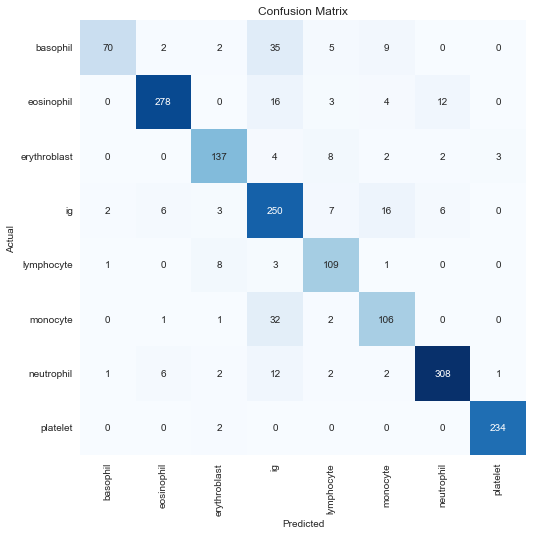

In [42]:
evaluator.show_classification_report()

- We can observe from the confusion matrix that the class for Immature Granulocytes (ig) is not being well predicted by the model. 
- For the other classes, there are significantly less misclassifications which is indicates that the pretrained model as such is not sufficient for this problem.
- Here, is where transfer learning comes into picture. We need to adapt resNet50 to given problem.

# Domain Adaptation - Fine Tuning of the model

We define a class Domain Adaptor which fine tunes the ResNet50 model to domain of Pathology using the cell images. This class has the following modules:
- Designing the model
- Compiling the model
- Fitting the model
- Plotting the Learning Curve

In [8]:
class DomainAdaptor:

    def __init__(self, train, val):
        self.train = train
        self.val = val
        self.model = None
        self.history = None
        self.fine_tune_from = 100
    
    def __load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def __mark_layers_trainable(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def __add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(8, 
                                 activation = 'softmax')(self.x)

    def design_model(self):
        self.__load_model()
        self.__mark_layers_trainable()
        self.__add_final_layer()

    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)
        self.model.compile(optimizer='adam', 
                           loss="categorical_crossentropy", 
                           metrics=['accuracy'])

    def fit_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=10, 
                                      validation_data=self.val,
                                      callbacks=[
                                                    tf.keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        patience=3,
                                                        restore_best_weights=True
                                                    )
                                                ]
                                    )

    def visualize_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

## Initialized the domain adaptor

In [17]:
domain_adaptor = DomainAdaptor(train, val)

## Minor tweaks to the ResNet50 model

In [18]:
domain_adaptor.design_model()

## Model compilation

In [19]:
domain_adaptor.compile_model()

## Model Fine Tuning

In [20]:
domain_adaptor.fit_model()

Epoch 1/10
428/428 [==============================] - 817s 2s/step - loss: 0.8966 - accuracy: 0.8133 - val_loss: 0.3778 - val_accuracy: 0.8721
Epoch 2/10
428/428 [==============================] - 820s 2s/step - loss: 0.2973 - accuracy: 0.9081 - val_loss: 0.4340 - val_accuracy: 0.8540
Epoch 3/10
428/428 [==============================] - 818s 2s/step - loss: 0.2268 - accuracy: 0.9297 - val_loss: 0.2205 - val_accuracy: 0.9267
Epoch 4/10
428/428 [==============================] - 821s 2s/step - loss: 0.1923 - accuracy: 0.9364 - val_loss: 0.6835 - val_accuracy: 0.8944
Epoch 5/10
428/428 [==============================] - 896s 2s/step - loss: 0.1517 - accuracy: 0.9527 - val_loss: 0.2253 - val_accuracy: 0.9343
Epoch 6/10
428/428 [==============================] - 917s 2s/step - loss: 0.0956 - accuracy: 0.9690 - val_loss: 0.2850 - val_accuracy: 0.9273


## Learning Curve of the model

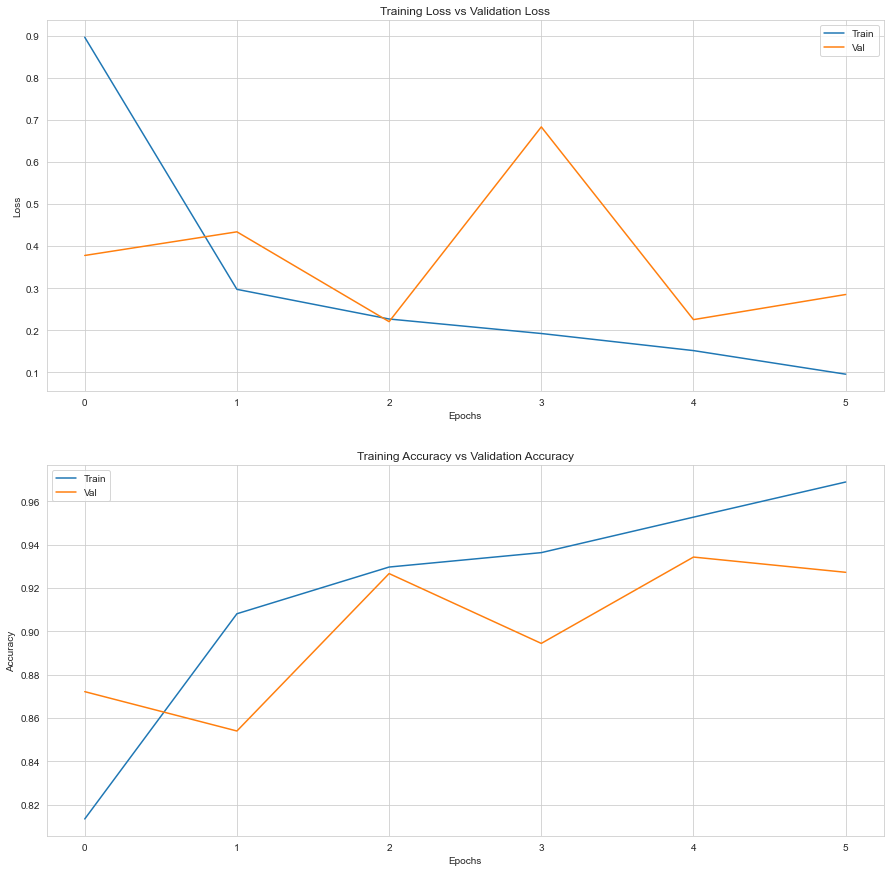

In [21]:
domain_adaptor.visualize_history()

## Initializing the Model Evaluator

In [23]:
evaluator = ModelEvaluator(domain_adaptor.model, domain_adaptor.train)

## Extracting the model's predictions on test data

In [24]:
evaluator.predict(test)

54/54 [==============================] - 35s 558ms/step


## Classification Report

### Confusion Matrix

Test Accuracy: 93.065%


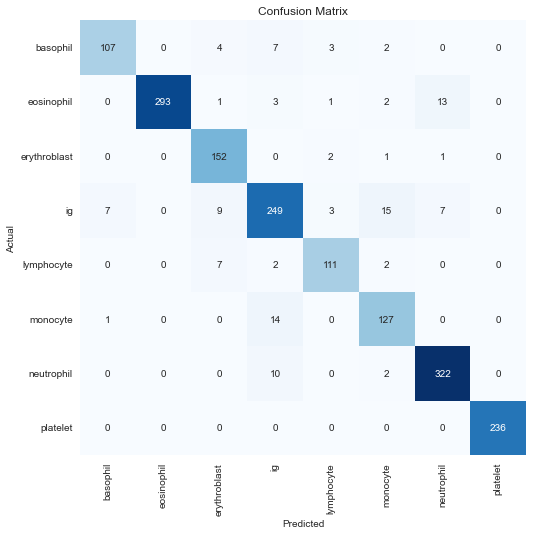

In [25]:
evaluator.show_classification_report()

We can observe that the class of Immature Granulocytes (ig) is being predicted better after domain adaptation resulting in an improvement in the accuracy of the model.

### Class-wise classification metrics

In [27]:
print(classification_report(test.labels, evaluator.predictions, target_names=evaluator.CLASS_NAMES))

              precision    recall  f1-score   support

    basophil       0.93      0.87      0.90       123
  eosinophil       1.00      0.94      0.97       313
erythroblast       0.88      0.97      0.92       156
          ig       0.87      0.86      0.87       290
  lymphocyte       0.93      0.91      0.92       122
    monocyte       0.84      0.89      0.87       142
  neutrophil       0.94      0.96      0.95       334
    platelet       1.00      1.00      1.00       236

    accuracy                           0.93      1716
   macro avg       0.92      0.93      0.92      1716
weighted avg       0.93      0.93      0.93      1716



- The pretrained ResNet50 model was overfitting for the problem at hand. 
- Hence, few layers of the ResNet50 model were made trainable and it was adapted to the Pathology Domain. 
- The resultant model has reduced overfitting significantly with Domain Adaptation and Early Stopping.

## Saving the model

In [47]:
domain_adaptor.model.save("../models/fine_tuned_model")

INFO:tensorflow:Assets written to: ../models/fine_tuned_model\assets


INFO:tensorflow:Assets written to: ../models/fine_tuned_model\assets


# Cross-validating the fine-tuned model

## Dataset split with 70-10-20 (train-val-test)

In [37]:
cell_type = Dataset(IMG_DIR="../data/cell-images", 
                    TRAIN=0.7, TEST=0.2, VAL=0.1,
                    split_dest="../data/bloods-cells-splitted-cross-validation")

## Test, Train, Validation Split

Here, we split the dataset into three directories by the ratio 70 : 20 : 10 (Train : Test : Validation)

In [38]:
cell_type.test_train_validation_split()

Copying files: 17092 files [03:14, 87.77 files/s] 


## Image preprocessing for the new split

### Initializing the Image Preprocessor

In [4]:
img_pre = ImageProcessor("../data/bloods-cells-splitted-cross-validation")

### Preprocessing the images as per the model requirements

In [5]:
img_pre.create_generators()

### Extracting the images in the required representation

In [6]:
train, val, test = img_pre.get_images()

Found 11959 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.
Found 3428 images belonging to 8 classes.


## Domain Adaptation

### Initializing the Domain Adaptator

In [9]:
domain_adaptor = DomainAdaptor(train, val)

### Designing the model

In [10]:
domain_adaptor.design_model()

### Compiling the model

In [11]:
domain_adaptor.compile_model()

### Fitting the model

In [12]:
domain_adaptor.fit_model()

Epoch 1/10
374/374 [==============================] - 750s 2s/step - loss: 0.8915 - accuracy: 0.8079 - val_loss: 0.4083 - val_accuracy: 0.8622
Epoch 2/10
374/374 [==============================] - 706s 2s/step - loss: 0.2546 - accuracy: 0.9092 - val_loss: 0.3017 - val_accuracy: 0.8897
Epoch 3/10
374/374 [==============================] - 744s 2s/step - loss: 0.1914 - accuracy: 0.9339 - val_loss: 0.3554 - val_accuracy: 0.8909
Epoch 4/10
374/374 [==============================] - 702s 2s/step - loss: 0.1923 - accuracy: 0.9442 - val_loss: 0.3003 - val_accuracy: 0.9056
Epoch 5/10
374/374 [==============================] - 741s 2s/step - loss: 0.1129 - accuracy: 0.9639 - val_loss: 0.3037 - val_accuracy: 0.9226
Epoch 6/10
374/374 [==============================] - 705s 2s/step - loss: 0.0732 - accuracy: 0.9729 - val_loss: 0.4149 - val_accuracy: 0.8909
Epoch 7/10
374/374 [==============================] - 775s 2s/step - loss: 0.0656 - accuracy: 0.9785 - val_loss: 0.3401 - val_accuracy: 0.9185

### Learning Curve 

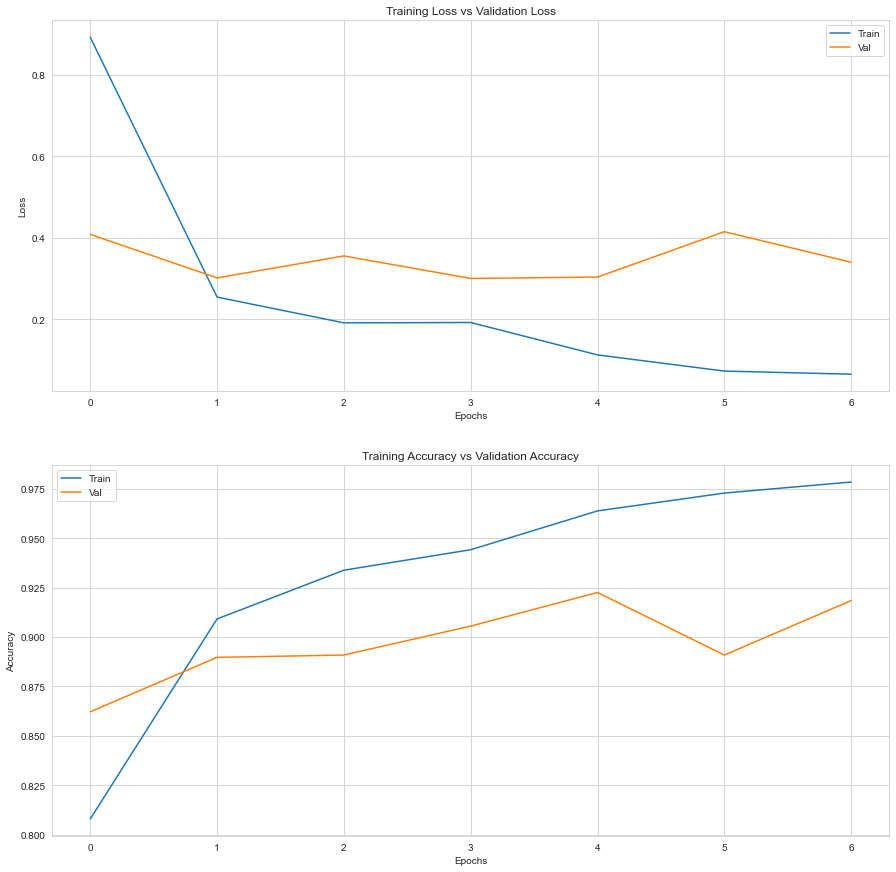

In [13]:
domain_adaptor.visualize_history()

### Model Evaluation of the Fine tuned model 

In [16]:
evaluator = ModelEvaluator(domain_adaptor.model, domain_adaptor.train)

### Extracting the model's predictions on test data

In [18]:
evaluator.predict(test)

108/108 [==============================] - 71s 629ms/step


### Classification report

#### Confusion matrix

Test Accuracy: 92.649%


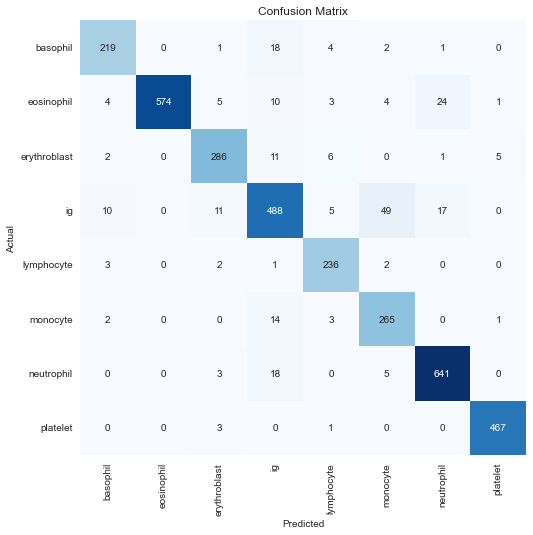

In [19]:
evaluator.show_classification_report()

#### Class-wise classification metrics

In [20]:
print(classification_report(test.labels, evaluator.predictions, target_names=evaluator.CLASS_NAMES))

              precision    recall  f1-score   support

    basophil       0.91      0.89      0.90       245
  eosinophil       1.00      0.92      0.96       625
erythroblast       0.92      0.92      0.92       311
          ig       0.87      0.84      0.86       580
  lymphocyte       0.91      0.97      0.94       244
    monocyte       0.81      0.93      0.87       285
  neutrophil       0.94      0.96      0.95       667
    platelet       0.99      0.99      0.99       471

    accuracy                           0.93      3428
   macro avg       0.92      0.93      0.92      3428
weighted avg       0.93      0.93      0.93      3428



- The approach is cross-validated with higher number of test images and we observe that accuracies for each class have decreased by a small factor or remained the same. 
- Hence, the model's performance proportionally decreases if the number of test images are increased by decreasing number of train images.

# Conclusions

- Atfirst we used ResNet50 model with the preset weights based on imagenet dataset for the blood cell classification. We get an accuracy of 95.35% on train dataset, 86.94% on test dataset, and 86.63% on validation dataset. This clears depicts that model has a low bias and a lower generalisation capability. (i.e high variance)

- Following to the overfitting, we tried to use Domain Adaptation and Early Stopping to improve the accuracy of model. We obtained an accuracy of 96.90% on train dataset, 93.06% on test dataset, and 92.73% on validation dataset. This is indicative of the higher generalisation capacbility. (i.e. low variance).

- Finally, we cross-validated the model to ensure that the accuracy of the model was just under current split. We divided the dataset into three directories train, test, and validation with a ratio of 70 : 20 : 10. We observe that the accuracy of the model proportionally decreases slightly. However, the confusion matrix is almost identical to the confusion matrix in the previous split.
(in terms of total misclassifications for each class)

- Hence, the approach of using Domain Adaptation is demonstrated in the notebook with the usage of Early Stopping to curb overfitting.

<u><b>Dataset Reference:</b></u>

Acevedo, Andrea; Merino, Anna; Alférez, Santiago; Molina, Ángel; Boldú, Laura; Rodellar, José (2020), “A dataset for microscopic peripheral blood cell images for development of automatic recognition systems”, Mendeley Data, V1, doi: 10.17632/snkd93bnjr.1